This example shows a simulation of a WDM system with a model as described in [my thesis](https://orbit.dtu.dk/en/publications/machine-learning-methods-in-coherent-optical-communication-system) section 2.3.2. The model is a variant of the model described in [1], but adjusted for a fiber-optic link without inline dispersion compensation. The model is computational less demanding than using the SSFM. However, I haven't investigated its accuracy systematically. Also, the model here only simulates inter-channel nonlinear effects or XPM effects. Intra-channel nonlinear effects or SPM effects are not modeled.

[1] https://ieeexplore.ieee.org/document/5709960

In [ ]:
%matplotlib inline
import matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os

In [2]:
import claude.utils as cu
import claude.tx as tx
import claude.claudeflow.systems as cfs
import claude.claudeflow.training as cft
import claude.claudeflow.helper as cfh
import claude.claudeflow.autoencoder as ae
import claude.claudeflow.models.SimpleXpmModel as cxpm

In [3]:
# Tx
param = cfs.defaultParameters(precision='double')

param.sps = 16
param.nSamples = 1024
param.PdBm  = 0

batch_size = 1
runs = 5
removeSymbols = 32
    
param.M     = 64
param.Fs    = param.sps * param.Rs
param.frequencyShift = False

param.N = param.sps * param.nSamples
print(param)

M:	64
nPol:	2
sps:	16
nSamples:	1024
rollOff:	0.05
filterSpan:	128
optimizeP:	False
PdBm:	0
Rs:	32000000000.0
channels:	[-100.  -50.    0.   50.  100.]
nChannels:	5
frequencyShift:	False
dispersionCompensation:	False
beta2:	2.0999953937404486e-26
dz:	1000000.0
Fs:	512000000000.0
N:	16384
realType:	<dtype: 'float64'>
complexType:	<dtype: 'complex128'>



In [4]:
xpmParam = cxpm.defaultParameters()
xpmParam.nSamples = param.nSamples
print(xpmParam)

nChannels:	5
nSpans:	10
nPol:	2
sps:	16
nSamples:	1024
Rs:	32000000000.0
noiseEnabled:	True
noiseFigure:	5
chSpacing:	50000000000.0
spanLength:	100
alpha:	0.2
gamma:	1.3
D:	16.464
simplified:	1
Fc:	193410000000000.0
precision:	double



In [5]:
# Constants
c = 299792458
constellation = tx.qammod(param.M)
print('const mean power: ', np.mean(np.abs(constellation)**2))
print('const.shape: ', constellation.shape)

const mean power:  1.0000000000000002
const.shape:  (1, 64)


In [6]:
def run_model(param, xpmParam):
    tf.reset_default_graph()

    nDims = 4 # Dimension of X
    X = tf.placeholder(tf.float32, shape=(None, param.nChannels, param.nPol, param.nSamples, param.M))
    constellation_tf = tf.constant(constellation, param.complexType)

    txSymbols = cfh.QAMencoder(X, constellation_tf, realOutput=False)

    signal = cfs.wdmTransmitter(txSymbols, param)

    signal_split = tf.split(signal, axis=1, num_or_size_splits=xpmParam.nChannels)
    signal_split = [tf.squeeze(sig, axis=1) for sig in signal_split]

    signal_out = cxpm.model(xpmParam, signal_split)

    signal_stack = tf.stack(signal_out, axis=1)

    rxSymbols = cfs.wdmReceiver(signal_stack, param)
    re_rxSymbols = rxSymbols

    #
    normP0 = tf.get_default_graph().get_tensor_by_name("normP0:0")
    rxSymbols = tf.cast( tf.rsqrt( normP0 ), param.complexType ) * rxSymbols

    # remove beginning and end of symbols
    rxSymbols, txSymbols = cfh.truncate(removeSymbols, rxSymbols, txSymbols)

    rxSymbols = cfh.staticPhaseRotationCompensation(rxSymbols)
    rxSymbols = cfh.testPhases(constellation_tf, txSymbols, rxSymbols, nDims, param.M, nTestPhases=4) 

    # metrics    
    reduce_axis = [0, 2, 3]
    errorrate = cfh.symbolErrorrate(constellation_tf, txSymbols, rxSymbols, nDims, param.M, reduce_axis)

    one = tf.constant( 1, param.realType )
    effSNR = cfh.effectiveSNR(txSymbols, rxSymbols, one, reduce_axis)

    # MI
    MI = []
    for (txChannel, rxChannel) in zip(tf.split(txSymbols, param.nChannels, axis=1), tf.split(rxSymbols, param.nChannels, axis=1)):
        MI_temp = cfh.gaussianMI(tf.reshape(txChannel,[-1]), tf.reshape(rxChannel,[-1]), constellation_tf, param.M)
        MI.append(MI_temp)

    MI = tf.stack(MI)    
    MI = tf.identity( MI, name='MI' )

    # only mid channel
    midChannel = param.nChannels//2
    errorrate = errorrate[midChannel]
    MI = MI[midChannel]
    effSNR = effSNR[midChannel]

    metricsDict = {'errorrate':errorrate, 'MI': MI, 'effSNR': effSNR}    
    meanMetricOpsDict, updateOps, resetOps = cft.create_mean_metrics(metricsDict)

    init = tf.global_variables_initializer()

    sess = tf.Session()
    sess.run(init)

    sess.run(resetOps)
    for mcRun in range(runs):
        print(mcRun, end=' ', flush=True)
        x, idx, x_seed = cu.hotOnes((batch_size, param.nChannels, param.nPol, param.nSamples),(1,2,3,4,0),param.M)
        feedDict = { X:x }
        sess.run(updateOps, feed_dict=feedDict)

    outMetrics = sess.run(list(meanMetricOpsDict.values()), feed_dict=feedDict)
    outMetrics = { key:val for key,val in zip(list(meanMetricOpsDict.keys()), outMetrics) }

    outString = ''
    for key, value in outMetrics.items():
        outString += ' - {}: {:.4f}'.format(key, value)
    print(outString, flush=True)

    # sess.close()
    print(' ')
    return outMetrics['errorrate'], outMetrics['MI'], outMetrics['effSNR'], sess, feedDict

In [7]:
powerSweep = np.arange(-8, 4+1, 2)
SSFeffSNR = np.zeros(powerSweep.shape)
SSFMI = np.zeros(powerSweep.shape)
sess = 0
feedDict = 0
for ii, PdBm in enumerate(powerSweep):
    print('PdBm: {}'.format(PdBm), end=' - ')
    param.PdBm = PdBm
    (avErrorrate, avMI, avEffSNR, sess, feedDict) = run_model(param, xpmParam)
    SSFeffSNR[ii] = avEffSNR
    SSFMI[ii] = avMI

PdBm: -8 - WARNING:tensorflow:
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

0 1 2 3 4  - errorrate: 0.6326 - MI: 3.4960 - effSNR: 10.8559
 
PdBm: -6 - 0 1 2 3 4  - errorrate: 0.5025 - MI: 4.0593 - effSNR: 12.8917
 
PdBm: -4 - 0 1 2 3 4  - errorrate: 0.3612 - MI: 4.6366 - effSNR: 14.8708
 
PdBm: -2 - 0 1 2 3 4  - errorrate: 0.2261 - MI: 5.1220 - effSNR: 16.6625
 
PdBm: 0 - 0 1 2 3 4  - errorrate: 0.1278 - MI: 5.4742 - effSNR: 18.1368
 
PdBm: 2 - 0 1 2 3 4  - errorrate: 0.0911 - MI: 5.6084 - effSNR: 18.8897
 
PdBm: 4 - 0 1 2 3 4  - errorrate: 0.1609 - MI: 5.3792 - effSNR: 17.7279
 


In [8]:
import claude.models.NLIN as nlin
# System parameters
qamParam = nlin.defaultParameters()
print(qamParam)

nPol:	2
lambda_:	1.55003597538907e-06
Fc:	193410000000000.0
D:	16.464
alpha:	0.2
beta2:	2.0999953937404486e-26
gamma:	1.3
nSpans:	10
spanLength:	100
noiseFigure:	5
PdBm:	1
Rs:	32
channels:	[-100.  -50.    0.   50.  100.]
nChannels:	5
chSpacing:	50
kur:	1.32
kur3:	1.96
N_mc:	1000000
PD:	0



In [9]:
# same as claude.models.NLIN.calcNLIN but without 'intra' and 'intraAdd'
def calcNLIN(param, powerSweep, aseNoisePower, interConst, interConstAdd):
    inter = np.zeros(powerSweep.shape)
    interAdd = np.zeros(powerSweep.shape)

    for ii,PdBm in enumerate(powerSweep):
        param.PdBm = PdBm
        inter[ii] = np.sum( nlin.calcInterChannelNLIN(interConst,param) )

        interAdd[ii] = np.sum( nlin.calcInterChannelNLINAddTerms(interConstAdd, param) )
    
    return cu.lin2dB( aseNoisePower+inter+interAdd, 'dBm')

    # as in claude.models.NLIN.calcNLIN:
    # return cu.lin2dB( aseNoisePower+inter+intra+interAdd+intraAdd, 'dBm') 

In [10]:
aseNoisePower, interConst, intraConst, interConstAdd, intraConstAdd = nlin.calcConstants(qamParam)
nlinPowerSweep = np.arange(-8, 4+1, 0.1)

In [11]:
# QAM
qam_constellation = np.squeeze(tx.qammod(param.M))
qamParam.kur, qamParam.kur3 = nlin.calcKur(qam_constellation)
qamEffSNR = nlinPowerSweep - calcNLIN(qamParam, nlinPowerSweep, aseNoisePower, interConst, interConstAdd)

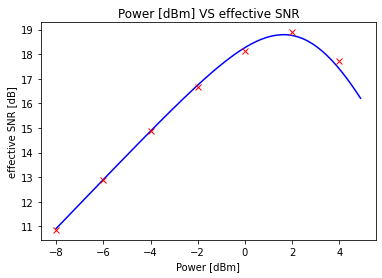

In [12]:
plt.plot(nlinPowerSweep, qamEffSNR, 'b')
plt.plot(powerSweep, SSFeffSNR, 'xr')
plt.title('Power [dBm] VS effective SNR')
plt.xlabel('Power [dBm]')
plt.ylabel('effective SNR [dB]')
plt.show()

In [ ]:
qamMI = np.zeros(np.shape(qamEffSNR))
N = 5e4

for ii,p in enumerate(nlinPowerSweep):
    qamMI[ii] = cu.SNRtoMI(N, qamEffSNR[ii], np.expand_dims(qam_constellation, 0))

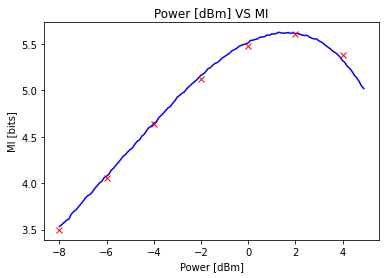

In [14]:
plt.plot(nlinPowerSweep, qamMI, 'b')
plt.plot(powerSweep, SSFMI, 'xr')
plt.title('Power [dBm] VS MI')
plt.xlabel('Power [dBm]')
plt.ylabel('MI [bits]')
plt.show()